# Convolutional Neural Networks

There are a lot  of algorithms that people used for image classification before **CNN** became popular. People used to create features from images and then feed those features into some classification algorithms like SVM or Logistic Regression. All machine learning algorithms require proper features for doing the classification, for example the pixel values can be used as a feature vector. You could train a SVM with 784 features where each feature is the pixel value of a 28x28 image.  

Before **CNN** we need to spend time on selecting the proper features for classifying the image, but it take so much time to select the proper ones and select the best model.  

CNN can handles all these problems and the accuracy of a **CNN** is higher compared with the normal classifier.  
But why **CNN** perform so much better?  

**CNN**s can be thought of automatic feature extractors from the image. If a use a classic model with pixel vector I lose a lot of spatial interaction between pixels, a **CNN** instead uses adjacent pixel information to effectively downsample the image first by convolution then uses a prediction layer at the end.

This concept was first presented by Yann LeCun in 1998 for digit classification where he used a single convolution layer. It was later popularized by **AlexNet** in 2012 which used multiple convolution layers to achieve state of art on imagenet. Thus making them the best algorithm choiche for image classification challanges henceforth.  
<br />

In this notebook we are going to implement, train and evaluate some different simple **CNN**. We'll try to tune hyperparameters and find a good model for the task and at the end there will be a recap with the accuracy associated with each model. Only the best attempts will be shown in order not to make the notebook too dispersive.



## Data Preparation

The dataset we have prepared in the previous notebooks are organized in subfolders, and each of them contain images of a different class. We'll use the *tensorflow* function "*image_dataset_from_directory()*" which is ideal for our case given that it infers labels from directory structure and names.

In [ ]:
#Importing the libraries
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy.random import seed
from tabulate import tabulate

In [ ]:
#Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Google Colab Version
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Tue Oct 25 09:58:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Unzipping all the datasets
train_path = '/content/drive/MyDrive/Age_Detection_Project/Data/Train.zip'
dev_path = '/content/drive/MyDrive/Age_Detection_Project/Data/Dev.zip'
test_path = '/content/drive/MyDrive/Age_Detection_Project/Data/Test.zip'
train_augmented_path = '/content/drive/MyDrive/Age_Detection_Project/Data/Train_Augmented.zip'

paths = [train_path, dev_path, test_path, train_augmented_path]

for path in paths:         
    with ZipFile(path, 'r') as myzip:
        myzip.extractall('../content/{}'.format(path.split('/')[-1].split('.')[0]))
        print('Done unzipping {}'.format(path.split('/')[-1]))

Done unzipping Train.zip
Done unzipping Dev.zip
Done unzipping Test.zip
Done unzipping Train_Augmented.zip


In [ ]:
#Naming the folders containing data
train_folder = '../content/Train'
dev_folder = '../content/Dev'
test_folder = '../content/Test'
train_augmented_folder = '../content/Train_Augmented'

In [ ]:
#Creating the tensorflow object containing the train, train augmented, validation and test datasets with original dimension
batch_size = 128

train_ds_original_size = tf.keras.utils.image_dataset_from_directory(
  train_folder,
  labels='inferred',
  label_mode='int',
  validation_split=None, #Fraction of data reserved for validation
  subset=None, #If we want to divide data in the folder in training and validation sets
  seed=41, #Seed should guarantee that training and validation set haven't common images
  shuffle=True,
  color_mode='rgb',
  image_size=(224, 224),
  batch_size=batch_size
  )

val_ds_original_size = tf.keras.utils.image_dataset_from_directory(
  dev_folder,
  labels='inferred',
  label_mode='int',
  validation_split=None,
  subset=None,
  seed=41, 
  shuffle=True,
  color_mode='rgb',
  image_size=(224, 224),
  batch_size=batch_size
  )

test_dataset_original_size = tf.keras.utils.image_dataset_from_directory(
  test_folder,
  labels='inferred',
  label_mode='int',
  validation_split=None,
  subset=None,
  seed=41, 
  shuffle=True,
  color_mode='rgb',
  image_size=(224, 224),
  batch_size=batch_size
  )

print('Batches for training -->', train_ds_original_size.cardinality())
print('Batches for validating -->', val_ds_original_size.cardinality())
print('Batches for testing -->', test_dataset_original_size.cardinality())

Found 23718 files belonging to 8 classes.
Found 5083 files belonging to 8 classes.
Found 5083 files belonging to 8 classes.
Batches for training --> tf.Tensor(186, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(40, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(40, shape=(), dtype=int64)


In [ ]:
#Creating the tensorflow object containing the train, train augmented, validation and test datasets with smaller size (50x50)
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_folder,
  labels='inferred',
  label_mode='int',
  validation_split=None, #Fraction of data reserved for validation
  subset=None, #If we want to divide data in the folder in training and validation sets
  seed=41, #Seed should guarantee that training and validation set haven't common images
  shuffle=True,
  color_mode='rgb',
  image_size=(50, 50),
  batch_size=batch_size
  )

train_augm_ds = tf.keras.utils.image_dataset_from_directory(
  train_augmented_folder,
  labels='inferred',
  label_mode='int',
  validation_split=None, 
  subset=None, 
  seed=41, 
  shuffle=True,
  color_mode='rgb',
  image_size=(50, 50),
  batch_size=batch_size
  )

train_augm_grayscale_ds = tf.keras.utils.image_dataset_from_directory(
  train_augmented_folder,
  labels='inferred',
  label_mode='int',
  validation_split=None, 
  subset=None, 
  seed=41, 
  shuffle=True,
  color_mode='grayscale',
  image_size=(50, 50),
  batch_size=batch_size
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  dev_folder,
  labels='inferred',
  label_mode='int',
  validation_split=None,
  subset=None,
  seed=41, 
  shuffle=True,
  color_mode='rgb',
  image_size=(50, 50),
  batch_size=batch_size
  )

val_grayscale_ds = tf.keras.utils.image_dataset_from_directory(
  dev_folder,
  labels='inferred',
  label_mode='int',
  validation_split=None,
  subset=None,
  seed=41, 
  shuffle=True,
  color_mode='grayscale',
  image_size=(50, 50),
  batch_size=batch_size
  )

test_dataset = tf.keras.utils.image_dataset_from_directory(
  test_folder,
  labels='inferred',
  label_mode='int',
  validation_split=None,
  subset=None,
  seed=41, 
  shuffle=True,
  color_mode='rgb',
  image_size=(50, 50),
  batch_size=batch_size
  )

test_dataset_grayscale = tf.keras.utils.image_dataset_from_directory(
  test_folder,
  labels='inferred',
  label_mode='int',
  validation_split=None,
  subset=None,
  seed=41, 
  shuffle=True,
  color_mode='grayscale',
  image_size=(50, 50),
  batch_size=batch_size
  )

print('Batches for training -->', train_ds.cardinality())
print('Batches for training augmented -->', train_augm_ds.cardinality())
print('Batches for validating -->', val_ds.cardinality())
print('Batches for testing -->', test_dataset.cardinality())

Found 23718 files belonging to 8 classes.
Found 166026 files belonging to 8 classes.
Found 166026 files belonging to 8 classes.
Found 5083 files belonging to 8 classes.
Found 5083 files belonging to 8 classes.
Found 5083 files belonging to 8 classes.
Found 5083 files belonging to 8 classes.
Batches for training --> tf.Tensor(186, shape=(), dtype=int64)
Batches for training augmented --> tf.Tensor(1298, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(40, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(40, shape=(), dtype=int64)


In [ ]:
#Defining a function to plot the model results
def plot_model_stats(train_loss, val_loss, train_accuracy, val_accuracy, title):
    fig, ax = plt.subplots(ncols=2, figsize=(15,7))

    ax = ax.ravel()

    ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
    ax[0].plot(val_loss, label='Validation Loss', color = 'orangered', marker='o', markersize=5)

    ax[0].set_xlabel('Epochs', fontsize=14)
    ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

    ax[0].legend(fontsize=14)
    ax[0].tick_params(axis='both', labelsize=12)

    ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
    ax[1].plot(val_accuracy, label='Validation Accuracy', color='orangered', marker='o', markersize=5)

    ax[1].set_xlabel('Epochs', fontsize=14)
    ax[1].set_ylabel('Accuracy', fontsize=14)

    ax[1].legend(fontsize=14)
    ax[1].tick_params(axis='both', labelsize=12)

    fig.suptitle(x=0.5, y=0.94, t=title, fontsize=16)

## Models

In this section we'll train and evaluate different **CNN** trying different possibilities as hyperparameters combination, changing dimension of the images or train the models on augmented data. As a base model we'll use a **CNN** with 3 convolutional layers followed by max pooling layers since it was the attemp that give the best result, anyway we only want to get an idea of a result that can be achieved. After that in the following notebook we'll more advanced technique to improve the accuracy.

### Model 1

Data Augmented: ✘<br />
L2 Regularization: ✘<br />
Dropout: ✘<br />
Grayscale: ✘<br />
Image Dimension Decreased: ✘<br />

In [ ]:
#Defining the model
model1 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(8, activation='softmax')
])

#Additionaly, if you do not one-hot encode your data, set sparse_categorical_crossentropy as loss and sparse_categorical_accuracy as metric.
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

# Defining the early stop to monitor the validation loss to avoid overfitting.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

#Training phase
epochs=50
model1_history = model1.fit(
  train_ds_original_size,
  validation_data=val_ds_original_size,
  callbacks=[early_stop],
  epochs=epochs,
  shuffle=True
)

Epoch 1/50
186/186 [==============================] - 63s 275ms/step - loss: 1.8566 - sparse_categorical_accuracy: 0.3311 - val_loss: 1.6672 - val_sparse_categorical_accuracy: 0.3791
Epoch 2/50
186/186 [==============================] - 49s 253ms/step - loss: 1.6015 - sparse_categorical_accuracy: 0.4043 - val_loss: 1.5670 - val_sparse_categorical_accuracy: 0.4148
Epoch 3/50
186/186 [==============================] - 48s 252ms/step - loss: 1.4569 - sparse_categorical_accuracy: 0.4540 - val_loss: 1.5057 - val_sparse_categorical_accuracy: 0.4427
Epoch 4/50
186/186 [==============================] - 49s 256ms/step - loss: 1.3226 - sparse_categorical_accuracy: 0.5087 - val_loss: 1.5020 - val_sparse_categorical_accuracy: 0.4520
Epoch 5/50
186/186 [==============================] - 48s 252ms/step - loss: 1.1413 - sparse_categorical_accuracy: 0.5786 - val_loss: 1.5903 - val_sparse_categorical_accuracy: 0.4293
Epoch 6/50
186/186 [==============================] - 49s 254ms/step - loss: 0.9352 -

In [ ]:
#Saving the train and validation loss and accuracy values from model1
train_loss1 = model1_history.history['loss']
val_loss1 = model1_history.history['val_loss']
train_accuracy1 = model1_history.history['sparse_categorical_accuracy']
val_accuracy1 = model1_history.history['val_sparse_categorical_accuracy']

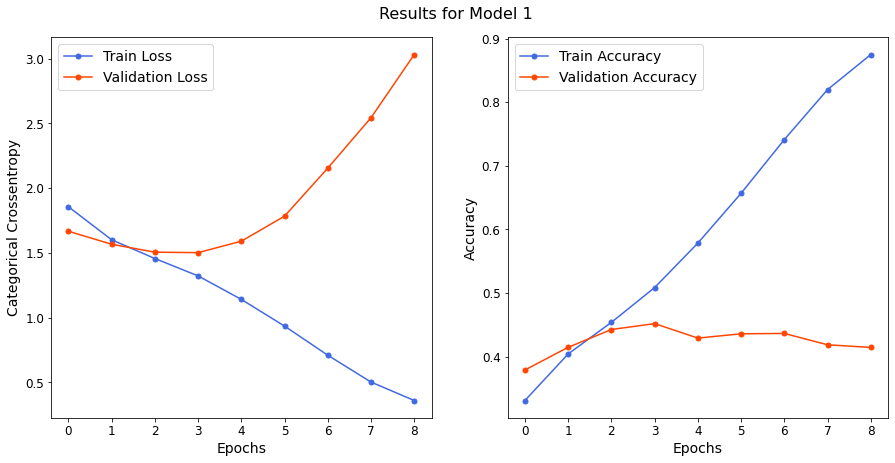

In [ ]:
#Plotting a line chart to visualize the loss and accuracy values by epochs
plot_model_stats(train_loss1, val_loss1, train_accuracy1, val_accuracy1, 'Results for Model 1')

In [ ]:
#Accuracy Evaluation
print('\n--------- MODEL 1 ----------\n')
model1_acc = round(model1.evaluate(test_dataset_original_size, verbose=0)[1] * 100, 2)
print("Model Accuracy: {}%".format(model1_acc))


--------- MODEL 1 ----------

Model Accuracy: 40.27%


The model return a base score of about 40% which is a good start. Now we'll try to improve the accuracy as much as possible. First of all let's try the same model on resized data (50x50).

### Model 2

Data Augmented: ✘<br />
L2 Regularization: ✘<br />
Dropout: ✘<br />
Grayscale: ✘<br />
Image Dimension Decreased: ✔<br />

In [ ]:
#Defining the model
model2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(50, 50, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(8, activation='softmax')
])

#Additionaly, if you do not one-hot encode your data, set sparse_categorical_crossentropy as loss and sparse_categorical_accuracy as metric.
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

# Defining the early stop to monitor the validation loss to avoid overfitting.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

#Training phase
epochs=50
model2_history = model2.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[early_stop],
  epochs=epochs,
  shuffle=True
)

Epoch 1/50
186/186 [==============================] - 38s 196ms/step - loss: 1.7993 - sparse_categorical_accuracy: 0.3418 - val_loss: 1.7094 - val_sparse_categorical_accuracy: 0.3680
Epoch 2/50
186/186 [==============================] - 38s 196ms/step - loss: 1.6353 - sparse_categorical_accuracy: 0.3913 - val_loss: 1.6089 - val_sparse_categorical_accuracy: 0.3995
Epoch 3/50
186/186 [==============================] - 37s 193ms/step - loss: 1.5277 - sparse_categorical_accuracy: 0.4303 - val_loss: 1.5119 - val_sparse_categorical_accuracy: 0.4352
Epoch 4/50
186/186 [==============================] - 37s 195ms/step - loss: 1.4529 - sparse_categorical_accuracy: 0.4550 - val_loss: 1.4940 - val_sparse_categorical_accuracy: 0.4342
Epoch 5/50
186/186 [==============================] - 37s 194ms/step - loss: 1.3835 - sparse_categorical_accuracy: 0.4804 - val_loss: 1.4823 - val_sparse_categorical_accuracy: 0.4415
Epoch 6/50
186/186 [==============================] - 37s 194ms/step - loss: 1.3168 -

In [ ]:
#Saving the train and validation loss and accuracy values from model2
train_loss2 = model2_history.history['loss']
val_loss2 = model2_history.history['val_loss']
train_accuracy2 = model2_history.history['sparse_categorical_accuracy']
val_accuracy2 = model2_history.history['val_sparse_categorical_accuracy']

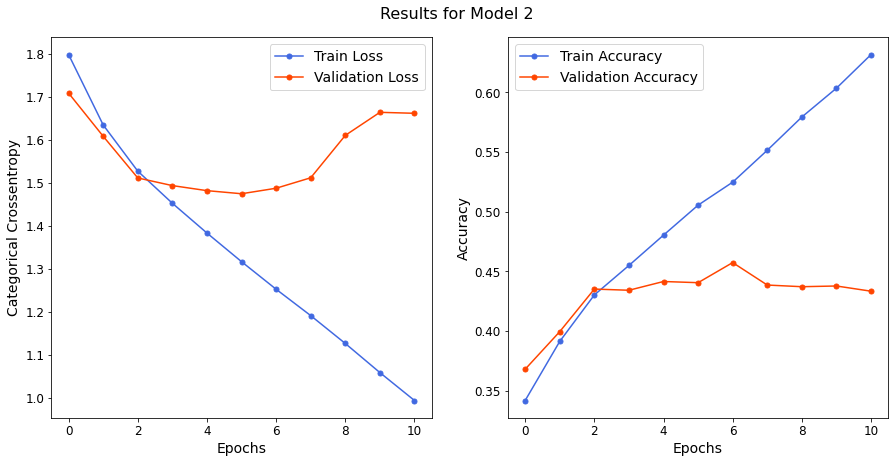

In [ ]:
#Plotting a line chart to visualize the loss and accuracy values by epochs
plot_model_stats(train_loss2, val_loss2, train_accuracy2, val_accuracy2, 'Results for Model 2')

In [ ]:
#Accuracy Evaluation
print('\n--------- MODEL 2 ----------\n')
model2_acc = round(model2.evaluate(test_dataset, verbose=0)[1] * 100, 2)
print("Model Accuracy: {}%".format(model2_acc))


--------- MODEL 2 ----------

Model Accuracy: 43.38%


Against the odds, the model with resized data (50x50 instead of 224x224) return a better performance. It could be to a lot of reasons, for example noise in images data or model on bigger dimension images create filters that tend to pay attention on background data instead of the main thing, 50x50 images can pay attention only to the foreground image.  

As we can see from the above graph, the model overfitted less then the first model but still there is a big overfitting problem since train accuracy is much higher than validation accuracy. Our model at the moment doesn't generalize well from the training data to unseen data.  

To solve the problem ***early stopping*** wasn't enough, in the next models we'll try to add some regularization (**L2 regularization** and **Dropout** layer) trying to reduce variance and the overfitting problem.

### Model 3

Data Augment: ✘<br />
L2 Regularization: ✔<br />
Dropout: ✔<br />
Grayscale: ✘<br />
Image Dimension Decreased: ✔<br />

In [ ]:
model3 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(50, 50, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8, activation='softmax')
])

#Additionaly, if you do not one-hot encode your data, set sparse_categorical_crossentropy as loss and sparse_categorical_accuracy as metric.
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

# Defining the early stop to monitor the validation loss to avoid overfitting.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

epochs=50
model3_history = model3.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[early_stop],
  epochs=epochs,
  shuffle=True
)

Epoch 1/50
186/186 [==============================] - 39s 197ms/step - loss: 2.0947 - sparse_categorical_accuracy: 0.3135 - val_loss: 1.8995 - val_sparse_categorical_accuracy: 0.3524
Epoch 2/50
186/186 [==============================] - 37s 194ms/step - loss: 1.8457 - sparse_categorical_accuracy: 0.3491 - val_loss: 1.8343 - val_sparse_categorical_accuracy: 0.3530
Epoch 3/50
186/186 [==============================] - 37s 193ms/step - loss: 1.7951 - sparse_categorical_accuracy: 0.3583 - val_loss: 1.7778 - val_sparse_categorical_accuracy: 0.3744
Epoch 4/50
186/186 [==============================] - 37s 194ms/step - loss: 1.7610 - sparse_categorical_accuracy: 0.3712 - val_loss: 1.7545 - val_sparse_categorical_accuracy: 0.3910
Epoch 5/50
186/186 [==============================] - 38s 195ms/step - loss: 1.7335 - sparse_categorical_accuracy: 0.3780 - val_loss: 1.7079 - val_sparse_categorical_accuracy: 0.3979
Epoch 6/50
186/186 [==============================] - 37s 194ms/step - loss: 1.7094 -

In [ ]:
#Saving the train and validation loss and accuracy values from model3
train_loss3 = model3_history.history['loss']
val_loss3 = model3_history.history['val_loss']
train_accuracy3 = model3_history.history['sparse_categorical_accuracy']
val_accuracy3 = model3_history.history['val_sparse_categorical_accuracy']

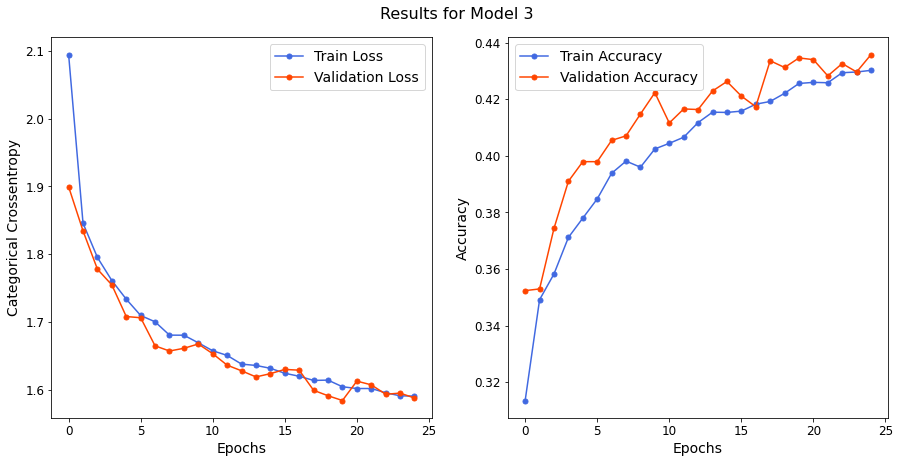

In [ ]:
#Plotting a line chart to visualize the loss and accuracy values by epochs
plot_model_stats(train_loss3, val_loss3, train_accuracy3, val_accuracy3, 'Results for Model 3')

In [ ]:
#Accuracy Evaluation
print('\n--------- MODEL 3 ----------\n')
model3_acc = round(model3.evaluate(test_dataset, verbose=0)[1] * 100, 2)
print("Model Accuracy: {}%".format(model3_acc))


--------- MODEL 3 ----------

Model Accuracy: 42.81%


Regularization techniques worked well, the model isn't overfitting anymore. Now let's try to only apply the **dropout** layers and check what happen to the performance.

### Model 4

Data Augment: ✘<br />
L2 Regularization: ✘<br />
Dropout: ✔<br />
Grayscale: ✘<br />
Image Dimension Decreased: ✔<br />

In [ ]:
model4 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(50, 50, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8, activation='softmax')
])

#Additionaly, if you do not one-hot encode your data, set sparse_categorical_crossentropy as loss and sparse_categorical_accuracy as metric.
model4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

# Defining the early stop to monitor the validation loss to avoid overfitting.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

epochs=50
model4_history = model4.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[early_stop],
  epochs=epochs,
  shuffle=True
)

Epoch 1/50
186/186 [==============================] - 38s 193ms/step - loss: 1.8683 - sparse_categorical_accuracy: 0.3168 - val_loss: 1.8964 - val_sparse_categorical_accuracy: 0.3401
Epoch 2/50
186/186 [==============================] - 37s 194ms/step - loss: 1.7612 - sparse_categorical_accuracy: 0.3540 - val_loss: 1.7811 - val_sparse_categorical_accuracy: 0.3742
Epoch 3/50
186/186 [==============================] - 37s 193ms/step - loss: 1.6899 - sparse_categorical_accuracy: 0.3731 - val_loss: 1.6871 - val_sparse_categorical_accuracy: 0.4039
Epoch 4/50
186/186 [==============================] - 37s 194ms/step - loss: 1.6341 - sparse_categorical_accuracy: 0.3906 - val_loss: 1.6444 - val_sparse_categorical_accuracy: 0.4160
Epoch 5/50
186/186 [==============================] - 38s 195ms/step - loss: 1.5906 - sparse_categorical_accuracy: 0.4091 - val_loss: 1.5995 - val_sparse_categorical_accuracy: 0.4289
Epoch 6/50
186/186 [==============================] - 37s 193ms/step - loss: 1.5604 -

In [ ]:
#Saving the train and validation loss and accuracy values from model4
train_loss4 = model4_history.history['loss']
val_loss4 = model4_history.history['val_loss']
train_accuracy4 = model4_history.history['sparse_categorical_accuracy']
val_accuracy4 = model4_history.history['val_sparse_categorical_accuracy']

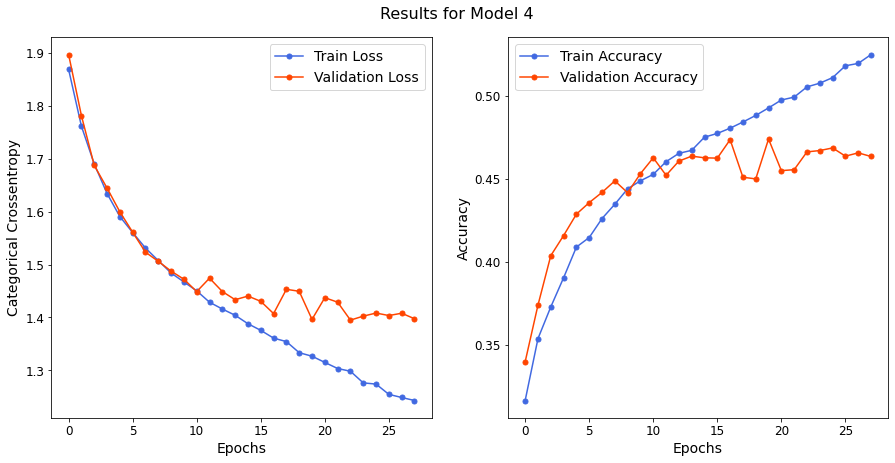

In [ ]:
#Plotting a line chart to visualize the loss and accuracy values by epochs
plot_model_stats(train_loss4, val_loss4, train_accuracy4, val_accuracy4, 'Results for Model 4')

In [ ]:
#Accuracy Evaluation
print('\n--------- MODEL 4 ----------\n')
model4_acc = round(model4.evaluate(test_dataset, verbose=0)[1] * 100, 2)
print("Model Accuracy: {}%".format(model4_acc))


--------- MODEL 4 ----------

Model Accuracy: 46.11%


The model seems to perform slightly better with only the dropout layers. Now I'll use augmented data for the training phase. This technique should makes the model perform better and accurately reducing the operational costs by introducing transformation in the datasets. 

### Model 5

Data Augment: ✔<br />
L2 Regularization: ✘<br />
Dropout: ✔<br />
Grayscale: ✘<br />
Image Dimension Decreased: ✔<br />

In [ ]:
model5 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(50, 50, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8, activation='softmax')
])

#Additionaly, if you do not one-hot encode your data, set sparse_categorical_crossentropy as loss and sparse_categorical_accuracy as metric.
model5.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

# Defining the early stop to monitor the validation loss to avoid overfitting.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

epochs=50
model5_history = model5.fit(
  train_augm_ds,
  validation_data=val_ds,
  callbacks=[early_stop],
  epochs=epochs,
  shuffle=True
)

Epoch 1/50
1298/1298 [==============================] - 56s 43ms/step - loss: 1.7369 - sparse_categorical_accuracy: 0.3597 - val_loss: 1.6154 - val_sparse_categorical_accuracy: 0.4209
Epoch 2/50
1298/1298 [==============================] - 55s 42ms/step - loss: 1.5876 - sparse_categorical_accuracy: 0.4111 - val_loss: 1.4687 - val_sparse_categorical_accuracy: 0.4511
Epoch 3/50
1298/1298 [==============================] - 54s 42ms/step - loss: 1.5217 - sparse_categorical_accuracy: 0.4319 - val_loss: 1.4729 - val_sparse_categorical_accuracy: 0.4497
Epoch 4/50
1298/1298 [==============================] - 55s 42ms/step - loss: 1.4794 - sparse_categorical_accuracy: 0.4460 - val_loss: 1.3986 - val_sparse_categorical_accuracy: 0.4744
Epoch 5/50
1298/1298 [==============================] - 54s 41ms/step - loss: 1.4445 - sparse_categorical_accuracy: 0.4583 - val_loss: 1.3852 - val_sparse_categorical_accuracy: 0.4764
Epoch 6/50
1298/1298 [==============================] - 54s 41ms/step - loss: 1.

In [ ]:
#Saving the train and validation loss and accuracy values from model5
train_loss5 = model5_history.history['loss']
val_loss5 = model5_history.history['val_loss']
train_accuracy5 = model5_history.history['sparse_categorical_accuracy']
val_accuracy5 = model5_history.history['val_sparse_categorical_accuracy']

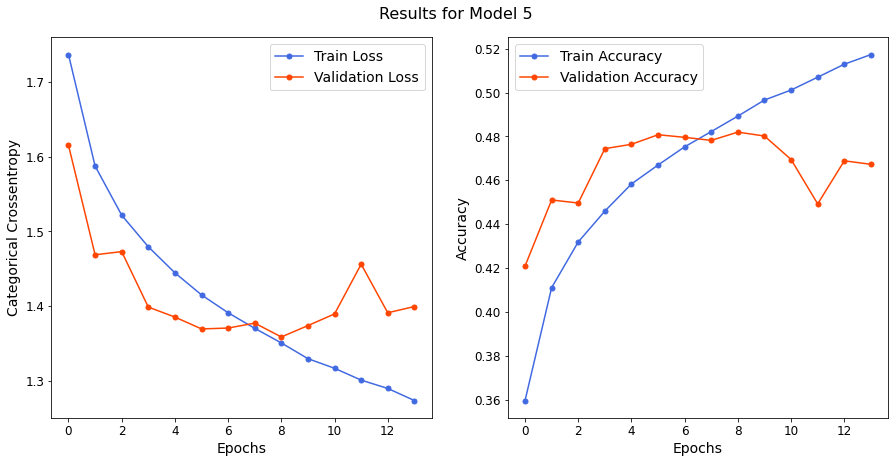

In [ ]:
#Plotting a line chart to visualize the loss and accuracy values by epochs
plot_model_stats(train_loss5, val_loss5, train_accuracy5, val_accuracy5, 'Results for Model 5')

In [ ]:
#Accuracy Evaluation
print('\n--------- MODEL 5 ----------\n')
model5_acc = round(model5.evaluate(test_dataset, verbose=0)[1] * 100, 2)
print("Model Accuracy: {}%".format(model5_acc))


--------- MODEL 5 ----------

Model Accuracy: 47.05%


The model improves of about 2% using augmented data in the training phase.  
In the next model we'll try to use a **GlobalMaxPool2D** layer instead of a **Flatten** layer.  
  
**Flatten** will take a tensor of any shape and transform it into a one dimensional tensor (plus the samples dimension) but keeping all values in the tensor. For example a tensor (samples, 10, 20, 1) will be flattened to (samples, 10 * 20 * 1).

**GlobalAveragePooling2D** does something different. It applies average pooling on the spatial dimensions until each spatial dimension is one, and leaves other dimensions unchanged. In this case values are not kept as they are averaged. For example a tensor (samples, 10, 20, 1) would be output as (samples, 1, 1, 1).

### Model 6

Data Augment: ✔<br />
L2 Regularization: ✘<br />
Dropout: ✔<br />
Grayscale: ✘<br />
Image Dimension Decreased: ✔<br />
GlobalMaxPool: ✔<br />

In [ ]:
model6 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(50, 50, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.GlobalMaxPool2D(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8, activation='softmax')
])

#Additionaly, if you do not one-hot encode your data, set sparse_categorical_crossentropy as loss and sparse_categorical_accuracy as metric.
model6.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

# Defining the early stop to monitor the validation loss to avoid overfitting.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

epochs=50
model6_history = model6.fit(
  train_augm_ds,
  validation_data=val_ds,
  callbacks=[early_stop],
  epochs=epochs,
  shuffle=True
)

Epoch 1/50
1298/1298 [==============================] - 55s 41ms/step - loss: 1.8379 - sparse_categorical_accuracy: 0.3307 - val_loss: 1.7535 - val_sparse_categorical_accuracy: 0.3698
Epoch 2/50
1298/1298 [==============================] - 54s 41ms/step - loss: 1.7102 - sparse_categorical_accuracy: 0.3715 - val_loss: 1.6132 - val_sparse_categorical_accuracy: 0.4092
Epoch 3/50
1298/1298 [==============================] - 54s 42ms/step - loss: 1.6463 - sparse_categorical_accuracy: 0.3910 - val_loss: 1.5683 - val_sparse_categorical_accuracy: 0.4182
Epoch 4/50
1298/1298 [==============================] - 54s 42ms/step - loss: 1.6045 - sparse_categorical_accuracy: 0.4041 - val_loss: 1.5984 - val_sparse_categorical_accuracy: 0.4041
Epoch 5/50
1298/1298 [==============================] - 54s 42ms/step - loss: 1.5794 - sparse_categorical_accuracy: 0.4130 - val_loss: 1.4967 - val_sparse_categorical_accuracy: 0.4445
Epoch 6/50
1298/1298 [==============================] - 54s 41ms/step - loss: 1.

In [ ]:
#Saving the train and validation loss and accuracy values from model6
train_loss6 = model6_history.history['loss']
val_loss6 = model6_history.history['val_loss']
train_accuracy6 = model6_history.history['sparse_categorical_accuracy']
val_accuracy6 = model6_history.history['val_sparse_categorical_accuracy']

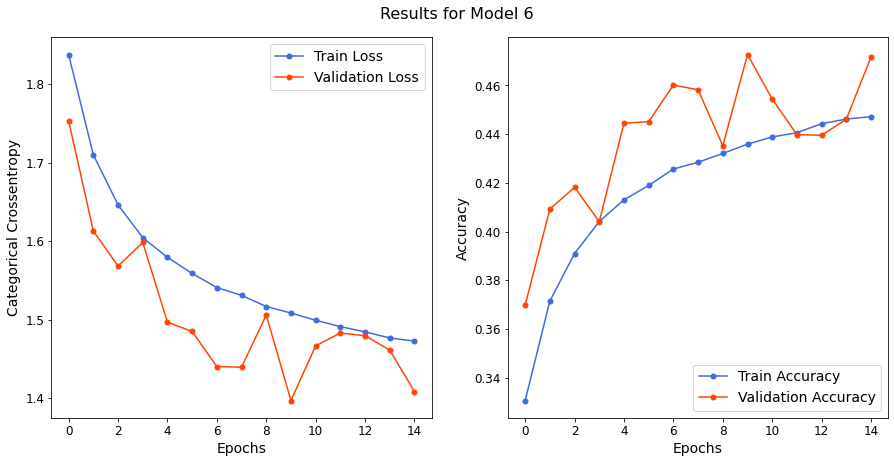

In [ ]:
#Plotting a line chart to visualize the loss and accuracy values by epochs
plot_model_stats(train_loss6, val_loss6, train_accuracy6, val_accuracy6, 'Results for Model 6')

In [ ]:
#Accuracy Evaluation
print('\n--------- MODEL 6 ----------\n')
model6_acc = round(model6.evaluate(test_dataset, verbose=0)[1] * 100, 2)
print("Model Accuracy: {}%".format(model6_acc))


--------- MODEL 6 ----------

Model Accuracy: 46.99%


The **GlobalMaxPooling** layer doesn't improve the model, we got about the same result.
In the next model we'll try to train the model with **grayscale** images.    

Usually the information contained in the grayscale image is enough for classification. For example, in this case a **grayscale** image of a person's face could be enough to identify him/her because a color image on the face won't add any substantial new information.  

In a larger network you need a big amount of parameters (for larger input vector). Training a larger number of parameters is difficult and will need many more training data, and number of iterations and despite all regularization efforts, they could still tend to overfit.  

So if the color doesn't add any valuable information, could be preferable to use grayscale images. Let's try and check the performance.



# MODEL 7

Data Augment: ✔<br />
L2 Regularization: ✘<br />
Dropout: ✔<br />
Grayscale: ✔<br />
Image Dimension Decreased: ✔<br />

In [ ]:
model7 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(50, 50, 1)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8, activation='softmax')
])

#Additionaly, if you do not one-hot encode your data, set sparse_categorical_crossentropy as loss and sparse_categorical_accuracy as metric.
model7.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

# Defining the early stop to monitor the validation loss to avoid overfitting.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

epochs=50
model7_history = model7.fit(
  train_augm_grayscale_ds,
  validation_data=val_grayscale_ds,
  callbacks=[early_stop],
  epochs=epochs,
  shuffle=True
)

Epoch 1/50
1298/1298 [==============================] - 44s 33ms/step - loss: 1.7530 - sparse_categorical_accuracy: 0.3544 - val_loss: 1.6121 - val_sparse_categorical_accuracy: 0.4189
Epoch 2/50
1298/1298 [==============================] - 44s 34ms/step - loss: 1.6194 - sparse_categorical_accuracy: 0.3992 - val_loss: 1.4790 - val_sparse_categorical_accuracy: 0.4522
Epoch 3/50
1298/1298 [==============================] - 43s 33ms/step - loss: 1.5606 - sparse_categorical_accuracy: 0.4182 - val_loss: 1.4461 - val_sparse_categorical_accuracy: 0.4614
Epoch 4/50
1298/1298 [==============================] - 43s 33ms/step - loss: 1.5206 - sparse_categorical_accuracy: 0.4312 - val_loss: 1.4508 - val_sparse_categorical_accuracy: 0.4518
Epoch 5/50
1298/1298 [==============================] - 43s 33ms/step - loss: 1.4906 - sparse_categorical_accuracy: 0.4418 - val_loss: 1.4853 - val_sparse_categorical_accuracy: 0.4405
Epoch 6/50
1298/1298 [==============================] - 44s 34ms/step - loss: 1.

In [ ]:
#Saving the train and validation loss and accuracy values from model7
train_loss7 = model7_history.history['loss']
val_loss7 = model7_history.history['val_loss']
train_accuracy7 = model7_history.history['sparse_categorical_accuracy']
val_accuracy7 = model7_history.history['val_sparse_categorical_accuracy']

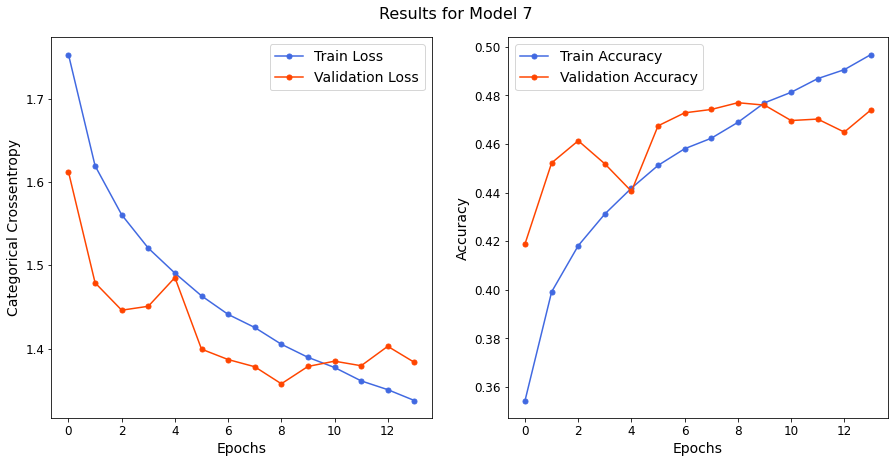

In [ ]:
#Plotting a line chart to visualize the loss and accuracy values by epochs
plot_model_stats(train_loss7, val_loss7, train_accuracy7, val_accuracy7, 'Results for Model 7')

In [ ]:
#Accuracy Evaluation
print('\n--------- MODEL 7 ----------\n')
model7_acc = round(model7.evaluate(test_dataset_grayscale, verbose=0)[1] * 100, 2)
print("Model Accuracy: {}%".format(model7_acc))


--------- MODEL 7 ----------

Model Accuracy: 46.95%


The model with grayscale data return the best performance until now.  
In the following notebooks we'll try advanced models and techniques in order to increase the actual accuracy.  

Here is a summary of the models tried in this notebook: 

In [ ]:
#Defining function to get percentage string from a number 
def perc(num):
  return str(round(float(num)*100, 2))+'%'

#Building the table of the result
table = [['\033[1m#\033[0m', '\033[1mModel Description\033[0m', '\033[1mTrain Loss\033[0m', '\033[1mVal Loss\033[0m', '\033[1mTrain Acc\033[0m', '\033[1mVal Acc\033[0m', '\033[1mTest Acc\033[0m'], 
         ['1', 'CNN basic infrastructure', str(round(train_loss1[-1], 3)), round(val_loss1[-1], 3), perc(train_accuracy1[-1]), perc(val_accuracy1[-1]), perc(model1_acc/100)],
         ['2','CNN with 50x50 images', round(train_loss2[-1], 3), round(val_loss2[-1], 3), perc(train_accuracy2[-1]), perc(val_accuracy2[-1]), perc(model2_acc/100)],
         ['3','CNN with 50x50 images and regularization (L2 & Dropout)', round(train_loss3[-1], 3), round(val_loss3[-1], 3), perc(train_accuracy3[-1]), perc(val_accuracy3[-1]), perc(model3_acc/100)],
         ['4','CNN with 50x50 images and regularization (Only Dropout)', round(train_loss4[-1], 3), round(val_loss4[-1], 3), perc(train_accuracy4[-1]), perc(val_accuracy4[-1]), perc(model4_acc/100)],
         ['5','CNN with 50x50 images, regularization (Only Dropout)\nand augmented data', round(train_loss5[-1], 3), round(val_loss5[-1], 3), perc(train_accuracy5[-1]), perc(val_accuracy5[-1]), perc(model5_acc/100)],
         ['6','CNN with 50x50 images, regularization (Only Dropout),\naugmented data and global max pool layer', round(train_loss6[-1], 3), round(val_loss6[-1], 3), perc(train_accuracy6[-1]), perc(val_accuracy6[-1]), perc(model6_acc/100)],
         ['7','CNN with 50x50 images, regularization (Only Dropout),\naugmented data and grayscale images', round(train_loss7[-1], 3), round(val_loss7[-1], 3), perc(train_accuracy7[-1]), perc(val_accuracy7[-1]), perc(model7_acc/100)]
        ]

#Printing the table
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))         

╒═════╤═════════════════════════════════════════════════════════╤══════════════╤════════════╤═════════════╤═══════════╤════════════╕
│   # │ Model Description                                       │   Train Loss │   Val Loss │ Train Acc   │ Val Acc   │ Test Acc   │
╞═════╪═════════════════════════════════════════════════════════╪══════════════╪════════════╪═════════════╪═══════════╪════════════╡
│   1 │ CNN basic infrastructure                                │        0.361 │      3.031 │ 87.5%       │ 41.46%    │ 40.27%     │
├─────┼─────────────────────────────────────────────────────────┼──────────────┼────────────┼─────────────┼───────────┼────────────┤
│   2 │ CNN with 50x50 images                                   │        0.993 │      1.663 │ 63.17%      │ 43.34%    │ 43.38%     │
├─────┼─────────────────────────────────────────────────────────┼──────────────┼────────────┼─────────────┼───────────┼────────────┤
│   3 │ CNN with 50x50 images and regularization (L2 & Dropout) │    